readings:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

In [2]:
!pip install seaborn

     |████████████████████████████████| 285 kB 2.8 MB/s eta 0:00:01


In [ ]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Titanic data-set
Can you predict who survived and who did not?

In [59]:
# data
test = pd.read_csv("../data/titanic/test.csv")
train = pd.read_csv("../data/titanic/train.csv")

In [60]:
total = train.isnull().sum().sort_values(ascending=False)
display(train.shape, test.shape)

(891, 12)

(418, 11)

In [61]:
total

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [63]:
# we have to get rid of the objects somehow:
train[['Name', 'Ticket', 'Cabin']].head()

,Name,Ticket,Cabin
0,"Braund, Mr. Owen Harris",A/5 21171,NaN
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123
4,"Allen, Mr. William Henry",373450,NaN


In [64]:
# Name is unique; Cabin hast to many Nans, Ticket is somehow unique too
train = train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket', 'Cabin'], axis = 1)

Next, we replace the string-variables with numeric (integer) variables and fill missing values in age with the most frequent age.

In [65]:
unique_embarked = set(train.Embarked.unique()).union(test.Embarked.unique())
embarked = dict(zip(unique_embarked, list(range(len(unique_embarked)))))
unique_sex = set(train.Sex.unique()).union(test.Sex.unique())
sex = dict(zip(unique_sex, list(range(len(unique_sex)))))

data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked)
    dataset['Sex'] = dataset['Sex'].map(sex)
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mode().values[0])    

not necessary, but we cast our categorical variables to data-type 'category'

In [66]:
categorical = [var for var in train.columns if train[var].dtype=='O']
numerical = [var for var in train.columns if train[var].dtype!='O']
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [72]:
categorical

[]

### we fit a RandomForest Classifier

In [73]:
survived = train['Survived']
train = train.drop('Survived', axis=1)
rf = RandomForestClassifier()
rf.fit(train, survived)

RandomForestClassifier()

### The RandomForest Classifier comes with an feature_importances_ attribute

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


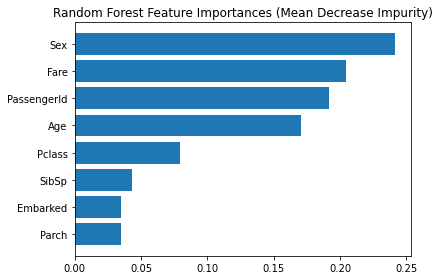

In [74]:
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Why is PassengerId such an important variable?

We could even enhance the information contained in PassengerId by target-encoding this variable.<br> No information is lost, results should not be worse.

By the way, what exactly are we doing in the for-loop?

In [76]:
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
k=5

encoder = CatBoostEncoder(cols = 'PassengerId')
folds = StratifiedKFold(n_splits = k, shuffle=True, random_state=1234)

test_PassId = np.zeros(test.shape[0])
train_trg = train.copy()
test_trg = test.copy()
for train_fold_idx, test_fold_idx in folds.split(train, survived):
    _ = encoder.fit_transform(train.loc[train_fold_idx], survived[train_fold_idx])
    train_trg.loc[test_fold_idx, :] = encoder.transform(train.loc[test_fold_idx])
    test_PassId += (encoder.transform(test)['PassengerId']/k)
test_trg['PassengerId'] = test_PassId

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  

In [77]:
display(test.head(), test_trg.head())

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,2
1,893,3,1,47.0,1,0,7.0000,3
2,894,2,0,62.0,0,0,9.6875,2
3,895,3,0,27.0,0,0,8.6625,3
4,896,3,1,22.0,1,1,12.2875,3


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.383838,3,0,34.5,0,0,7.8292,2
1,0.383838,3,1,47.0,1,0,7.0000,3
2,0.383838,2,0,62.0,0,0,9.6875,2
3,0.383838,3,0,27.0,0,0,8.6625,3
4,0.383838,3,1,22.0,1,1,12.2875,3


/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


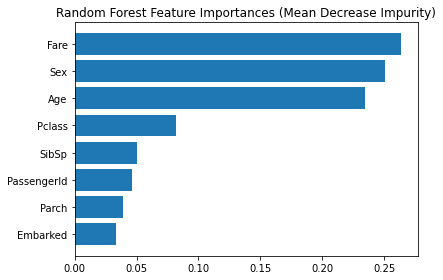

In [78]:
rf = RandomForestClassifier()
rf.fit(train_trg, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

### Surprise!
What exactly happend? The relevant information about the target should still be contained in the mean-encoded PassengerId-variable.

### Can we make the old PassengerId-variable shine even brighter?

In [ ]:
encoder = OneHotEncoder(cols = ['Age', 'Sex'])
train_oh = encoder.fit_transform(train)
test_oh = encoder.transform(test)

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


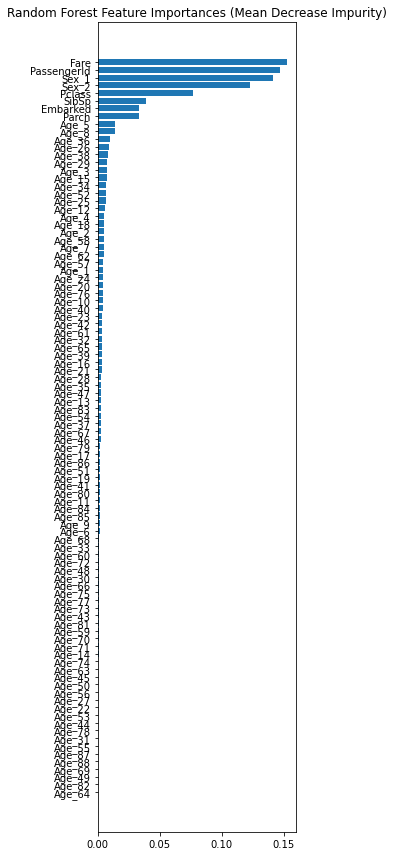

In [82]:
rf = RandomForestClassifier()
rf.fit(train_oh, survived)
tree_feature_importances = rf.feature_importances_
feature_names = train_oh.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(4, 12))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (Mean Decrease Impurity)")
fig.tight_layout()
plt.show()

# Gini-coefficient (gini impurity) for splitting variables

\begin{equation*}
\text{gini}=1-\sum_i^n P_i^2 
\end{equation*}
where $i$ is the class index;
The gini impurity measueres the purity of a node. If all elements within one node fall in one class, $P_i=1$ and the impurity is at its minimum.<br>
Gini impurity favours splitting repeatedly on continuous variables and thus cutting out regions of very low impurity. The continuous variable itself might even contain no real information at all (PassengerId).

# Permutation variable importance

In [83]:
train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,3
1,2,1,1,38.0,1,0,71.2833,1
2,3,3,1,26.0,0,0,7.9250,3
3,4,1,1,35.0,1,0,53.1000,3
4,5,3,0,35.0,0,0,8.0500,3


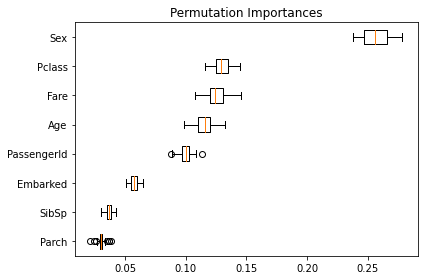

In [88]:
from sklearn.inspection import permutation_importance

rf_model = RandomForestClassifier()
rf_model.fit(train, survived)
result = permutation_importance(rf_model, train, survived,
        n_repeats=30,
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

# experiment
How well would a random variable perform?
  - some values are repeating but random
  - all values are unique and random

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


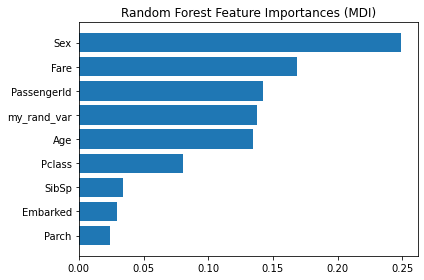

In [89]:
# simple random variable not all values unique (vs. PassengerId)

from numpy.random import randint
train_rand = train.copy()
train_rand['my_rand_var'] = randint(0, train.shape[0], train.shape[0])
rf_rand = RandomForestClassifier()
rf_rand.fit(train_rand, survived)
tree_feature_importances = rf_rand.feature_importances_
feature_names = train_rand.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

When we repeatedly execute the cell below, in most cases the variable 'my_unique_rand_var' has a higher feature_importance than the 'my_unique_rand_var_sorted' variable.<br>
Why is this?<br>
Values of both variables are unique. There should be no sorting in the target-variable within the data-frame.

/home/martin/miniconda3/envs/imbalanced/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


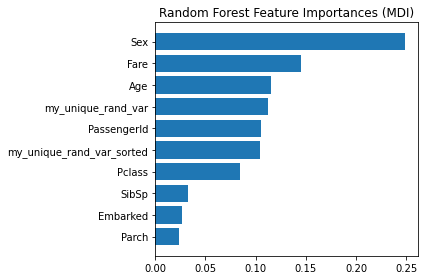

In [111]:
# simple random variable all values unique (vs. PassengerId)

from numpy.random import choice
train_rand_all_unique = train.copy()
train_rand_all_unique['my_unique_rand_var'] = choice(np.arange(train.shape[0]), train.shape[0], replace=False)
train_rand_all_unique['my_unique_rand_var_sorted'] = np.arange(train.shape[0])
rf_rand_all_unique = RandomForestClassifier()
rf_rand_all_unique.fit(train_rand_all_unique, survived)
tree_feature_importances = rf_rand_all_unique.feature_importances_
feature_names = train_rand_all_unique.columns
sorted_idx = tree_feature_importances.argsort()
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [112]:
train_rand_all_unique.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,my_unique_rand_var,my_unique_rand_var_sorted
0,1,3,0,22.0,1,0,7.2500,3,391,0
1,2,1,1,38.0,1,0,71.2833,1,302,1
2,3,3,1,26.0,0,0,7.9250,3,574,2
3,4,1,1,35.0,1,0,53.1000,3,205,3
4,5,3,0,35.0,0,0,8.0500,3,456,4


### Interpretation
For the interpretation of the importance-scores, this is highly relevant. As we see, PassengerId and my_unique_rand_var_sorted are highly redundant. Nonetheless, both have very high importance-scores; The accuracy of the model will not degrade if we remove one of the variables - even though both have high importance.